<a href="https://colab.research.google.com/github/ellie456789/STA365HW/blob/main/HW7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Question 1 - part 1
we are given : \\
$$
\text{likelihood:} ∝ exp(\frac{-1}{2}(y-X\beta)ᵀ (\sigma^2I)^{-1}(y-X\beta))
$$
simplifies:
$$
∝ exp(\frac{-1}{2\sigma^2}(y-X\beta)ᵀ (y-X\beta))\\
\text{and}\\
p(\beta) ∝ MVN(\beta_0, (\sigma^2Ι)_\beta)\\
∝ exp(\frac{-1}{2}(\beta-\beta_0)ᵀ (\sigma^2Ι)^{-1}(\beta-\beta_0)\\
∝ exp(\frac{-1}{2\sigma^2} (\beta-\beta_0)ᵀ(\beta-\beta_0))\\
\text{we need to drive } p(\beta|y, x, sigma^2Ι) \text{ for linear regression}
$$


using Baye's theroem :

$$
p(\beta|y,X,\sigma^2) = \frac{p(y|\beta, \sigma^2, X)p(\beta)}{p(y|X, \sigma^2)}\\
∝ likelihood × p(\beta)\\
= exp(\frac{-1}{2\sigma^2}(y-X\beta)ᵀ (y-X\beta))exp(\frac{-1}{2\sigma^2} (\beta-\beta_0)ᵀ(\beta-\beta_0)
= exp[\frac{-1}{2\sigma^2}(y-X\beta)ᵀ(y-X\beta) + (\beta-\beta_0)ᵀ(\beta-\beta_0)]
=MVN((XᵀX + Ι)^{-1}(Xᵀy + \beta_0), \sigma^2(XᵀX + Ι)^{-1})
$$


Analytical Posterior Mean: [ 0.9210437  -0.56689462  1.88185323]
Analytical Posterior Covariance:
 [[0.01473469 0.00102579 0.00134173]
 [0.00102579 0.01032602 0.00130915]
 [0.00134173 0.00130915 0.00831926]]
Log-posterior at analytical mean: -40.82393561325433


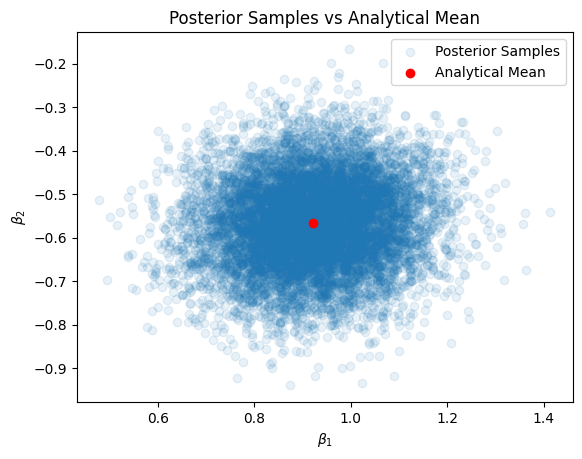

In [ ]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt


np.random.seed(42)
n_samples = 100
n_features = 3
sigma2 = 1.0
beta_0 = np.zeros(n_features)

#data
X = np.random.randn(n_samples, n_features)  #matrix X
beta_true = np.array([1.0, -0.5, 2.0])     # True beta
noise = np.random.normal(0, np.sqrt(sigma2), n_samples)  # Gaussian noise

XTX = X.T @ X
XTy = X.T @ y


I = np.eye(n_features)

# Posterior covariance
posterior_cov = sigma2 * np.linalg.inv(XTX + I)

# Posterior mean
posterior_mean = np.linalg.inv(XTX + I) @ (XTy + beta_0)

print("Analytical Posterior Mean:", posterior_mean)
print("Analytical Posterior Covariance:\n", posterior_cov)

def log_posterior(beta, X, y, sigma2, beta_0):
    # Log likelihood
    residual = y - X @ beta
    log_likelihood = -0.5 / sigma2 * np.sum(residual**2)

    # Log prior
    prior_diff = beta - beta_0
    log_prior = -0.5 / sigma2 * np.sum(prior_diff**2)

    return log_likelihood + log_prior

# Test
log_post_at_mean = log_posterior(posterior_mean, X, y, sigma2, beta_0)
print("Log-posterior at analytical mean:", log_post_at_mean)

posterior_dist = stats.multivariate_normal(mean=posterior_mean, cov=posterior_cov)
beta_samples = posterior_dist.rvs(size=10000)

# Plot
plt.scatter(beta_samples[:, 0], beta_samples[:, 1], alpha=0.1, label="Posterior Samples")
plt.scatter(posterior_mean[0], posterior_mean[1], color='red', label="Analytical Mean")
plt.xlabel(r'$\beta_1$')
plt.ylabel(r'$\beta_2$')
plt.legend()
plt.title("Posterior Samples vs Analytical Mean")
plt.show()

In [ ]:
import pymc as pm

with pm.Model() as model:
    # Prior on beta
    beta = pm.MvNormal('beta', mu=beta_0, cov=sigma2 * np.eye(n_features), shape=n_features)
    # Likelihood
    y_pred = pm.math.dot(X, beta)
    y_obs = pm.Normal('y_obs', mu=y_pred, sigma=np.sqrt(sigma2), observed=y)
    # Sample from the posterior
    trace = pm.sample(1000, tune=1000, return_inferencedata=False)

mcmc_mean = np.mean(trace['beta'], axis=0)
mcmc_cov = np.cov(trace['beta'].T)

print("MCMC Posterior Mean:", mcmc_mean)
print("MCMC Posterior Covariance:\n", mcmc_cov)

# Compare
print("\nDifference in Means (Analytical - MCMC):", posterior_mean - mcmc_mean)
print("Difference in Covariances (Analytical - MCMC):\n", posterior_cov - mcmc_cov)

# Question 1 - part 2
$$
\text{assuming } \sigma^2 \text{ has inverse gamma prioir distribution}\\
p(\sigma^2) ∝ \text{Inv Gamma } (\alpha^*, \beta^*)\\
\text{from inverse gamma function: } f(x;\alpha, \beta) = \frac{\beta^\alpha}{Γ{\alpha}} (\frac{1}{X})^-({\alpha +1})exp^{\frac{-\beta}{X}}\\
\propto (\frac{1}{\sigma^2})^-({\alpha +1})exp^{\frac{-\beta^*}{\sigma^2}}\\
\text{also from the question, } \sigma^2 = \text{ error variance of linear regression model}\\
ɛ\approx N(0, \sigma^2Ι) \text{ then } p(y|X, \beta, \sigma^2) \text{ follow } N(X\beta, \sigma^2Ι) \propto (\sigma^2)^{\frac{-n}{2}}exp(\frac{-1}{2\sigma^2} (y-X\beta)ᵀ(y-X\beta))\\
\text{integrating } \beta^*
\text{from Baye's thereom : } p(\sigma^2|y, X) = prioir × likelihood\\
\propto  (\frac{1}{\sigma^2})^-({\alpha +1})exp^{\frac{-\beta}{\sigma^2}} × (\sigma^2)^{\frac{-n}{2}}exp(\frac{-1}{2\sigma^2} (y-X\beta)ᵀ(y-X\beta)\\
\propto (\sigma^2)^{-(\frac{n}{2} + \alpha^* +1)} exp \frac{-1}{\sigma^2} (\frac{(y-x\beta)ᵀ(y-x\beta)}{2} + \beta^*)\\
\propto \text{INV GAMMA } (\alpha^* +\frac{n}{2}, \frac{(y-x\beta)ᵀ(y-x\beta)}{2} + \beta^*)
$$

Posterior Shape (alpha): 52.0
Posterior Scale (mu): 39.46840432475903


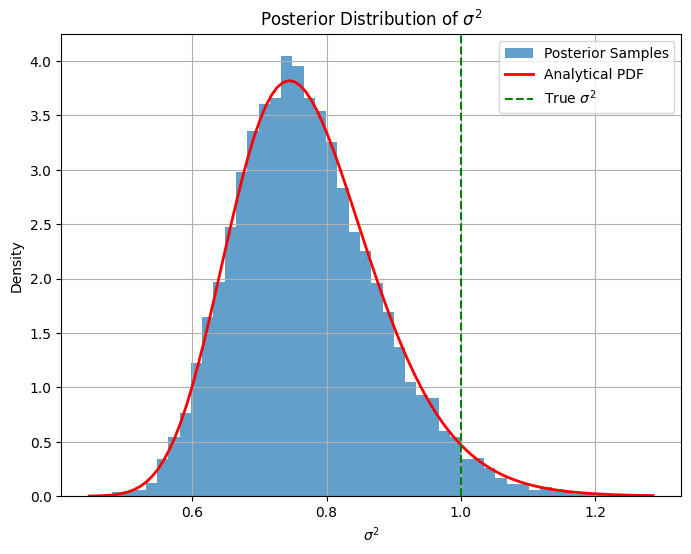

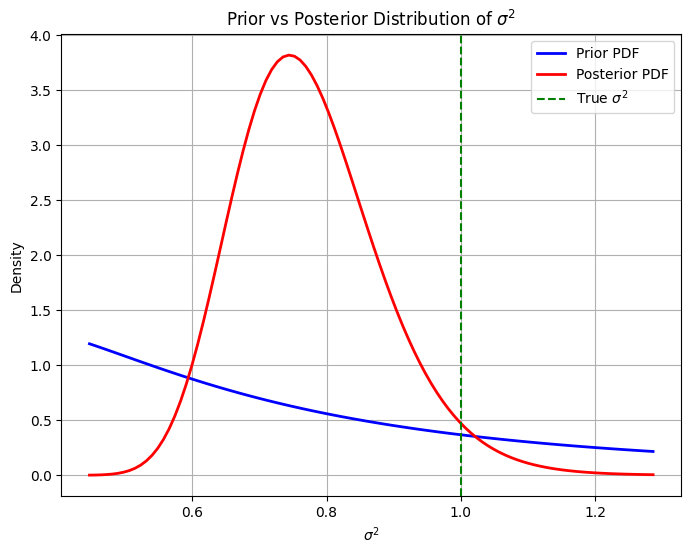

In [ ]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

np.random.seed(42)
n_samples = 100
n_features = 3
alpha_star = 2.0
mu_star = 1.0
beta_0 = np.zeros(n_features)
sigma2_true = 1.0

#data
X = np.random.randn(n_samples, n_features)
beta_true = np.array([1.0, -0.5, 2.0])
noise = np.random.normal(0, np.sqrt(sigma2_true), n_samples)
y = X @ beta_true + noise
XTX = X.T @ X
XTy = X.T @ y
I = np.eye(n_features)
beta_hat = np.linalg.inv(XTX + I) @ (XTy + beta_0)

#Compute residual sum of squares
residuals = y - X @ beta_hat
RSS = np.sum(residuals**2)

#sigma^2
alpha_post = alpha_star + n_samples / 2
mu_post = mu_star + RSS / 2

print("Posterior Shape (alpha):", alpha_post)
print("Posterior Scale (mu):", mu_post)

#sample
sigma2_samples = stats.invgamma.rvs(a=alpha_post, scale=mu_post, size=10000)

# Plot
plt.figure(figsize=(8, 6))
plt.hist(sigma2_samples, bins=50, density=True, alpha=0.7, label="Posterior Samples")
x = np.linspace(min(sigma2_samples), max(sigma2_samples), 100)
plt.plot(x, stats.invgamma.pdf(x, a=alpha_post, scale=mu_post), 'r-', lw=2, label="Analytical PDF")
plt.axvline(sigma2_true, color='g', linestyle='--', label="True $\sigma^2$")
plt.xlabel(r'$\sigma^2$')
plt.ylabel("Density")
plt.title("Posterior Distribution of $\sigma^2$")
plt.legend()
plt.grid(True)
plt.show()

# Compare with prior
plt.figure(figsize=(8, 6))
plt.plot(x, stats.invgamma.pdf(x, a=alpha_star, scale=mu_star), 'b-', lw=2, label="Prior PDF")
plt.plot(x, stats.invgamma.pdf(x, a=alpha_post, scale=mu_post), 'r-', lw=2, label="Posterior PDF")
plt.axvline(sigma2_true, color='g', linestyle='--', label="True $\sigma^2$")
plt.xlabel(r'$\sigma^2$')
plt.ylabel("Density")
plt.title("Prior vs Posterior Distribution of $\sigma^2$")
plt.legend()
plt.grid(True)
plt.show()

# Question 2

data set I've chosen

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Output()

MCMC Diagnostics:
           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
betas[0] -0.001  0.027  -0.051    0.049      0.000    0.000    4931.0   
betas[1]  0.597  0.030   0.540    0.653      0.000    0.000    4001.0   
betas[2]  0.080  0.032   0.021    0.142      0.000    0.000    4267.0   
betas[3]  0.103  0.048   0.011    0.190      0.001    0.001    2665.0   
betas[4] -0.007  0.045  -0.089    0.082      0.001    0.001    3024.0   
betas[5] -0.272  0.031  -0.333   -0.217      0.000    0.000    3923.0   
betas[6]  0.055  0.029  -0.001    0.109      0.000    0.000    4420.0   
betas[7]  0.165  0.029   0.113    0.220      0.000    0.000    3779.0   
sigma     0.611  0.019   0.576    0.648      0.000    0.000    4989.0   

          ess_tail  r_hat  
betas[0]    3027.0    1.0  
betas[1]    3176.0    1.0  
betas[2]    3349.0    1.0  
betas[3]    3077.0    1.0  
betas[4]    2649.0    1.0  
betas[5]    3110.0    1.0  
betas[6]    3102.0    1.0  
betas[7]    3085.0    1.0  

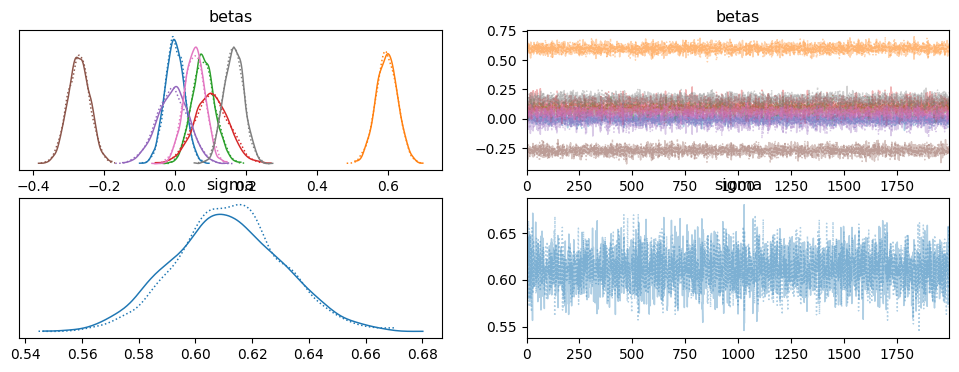

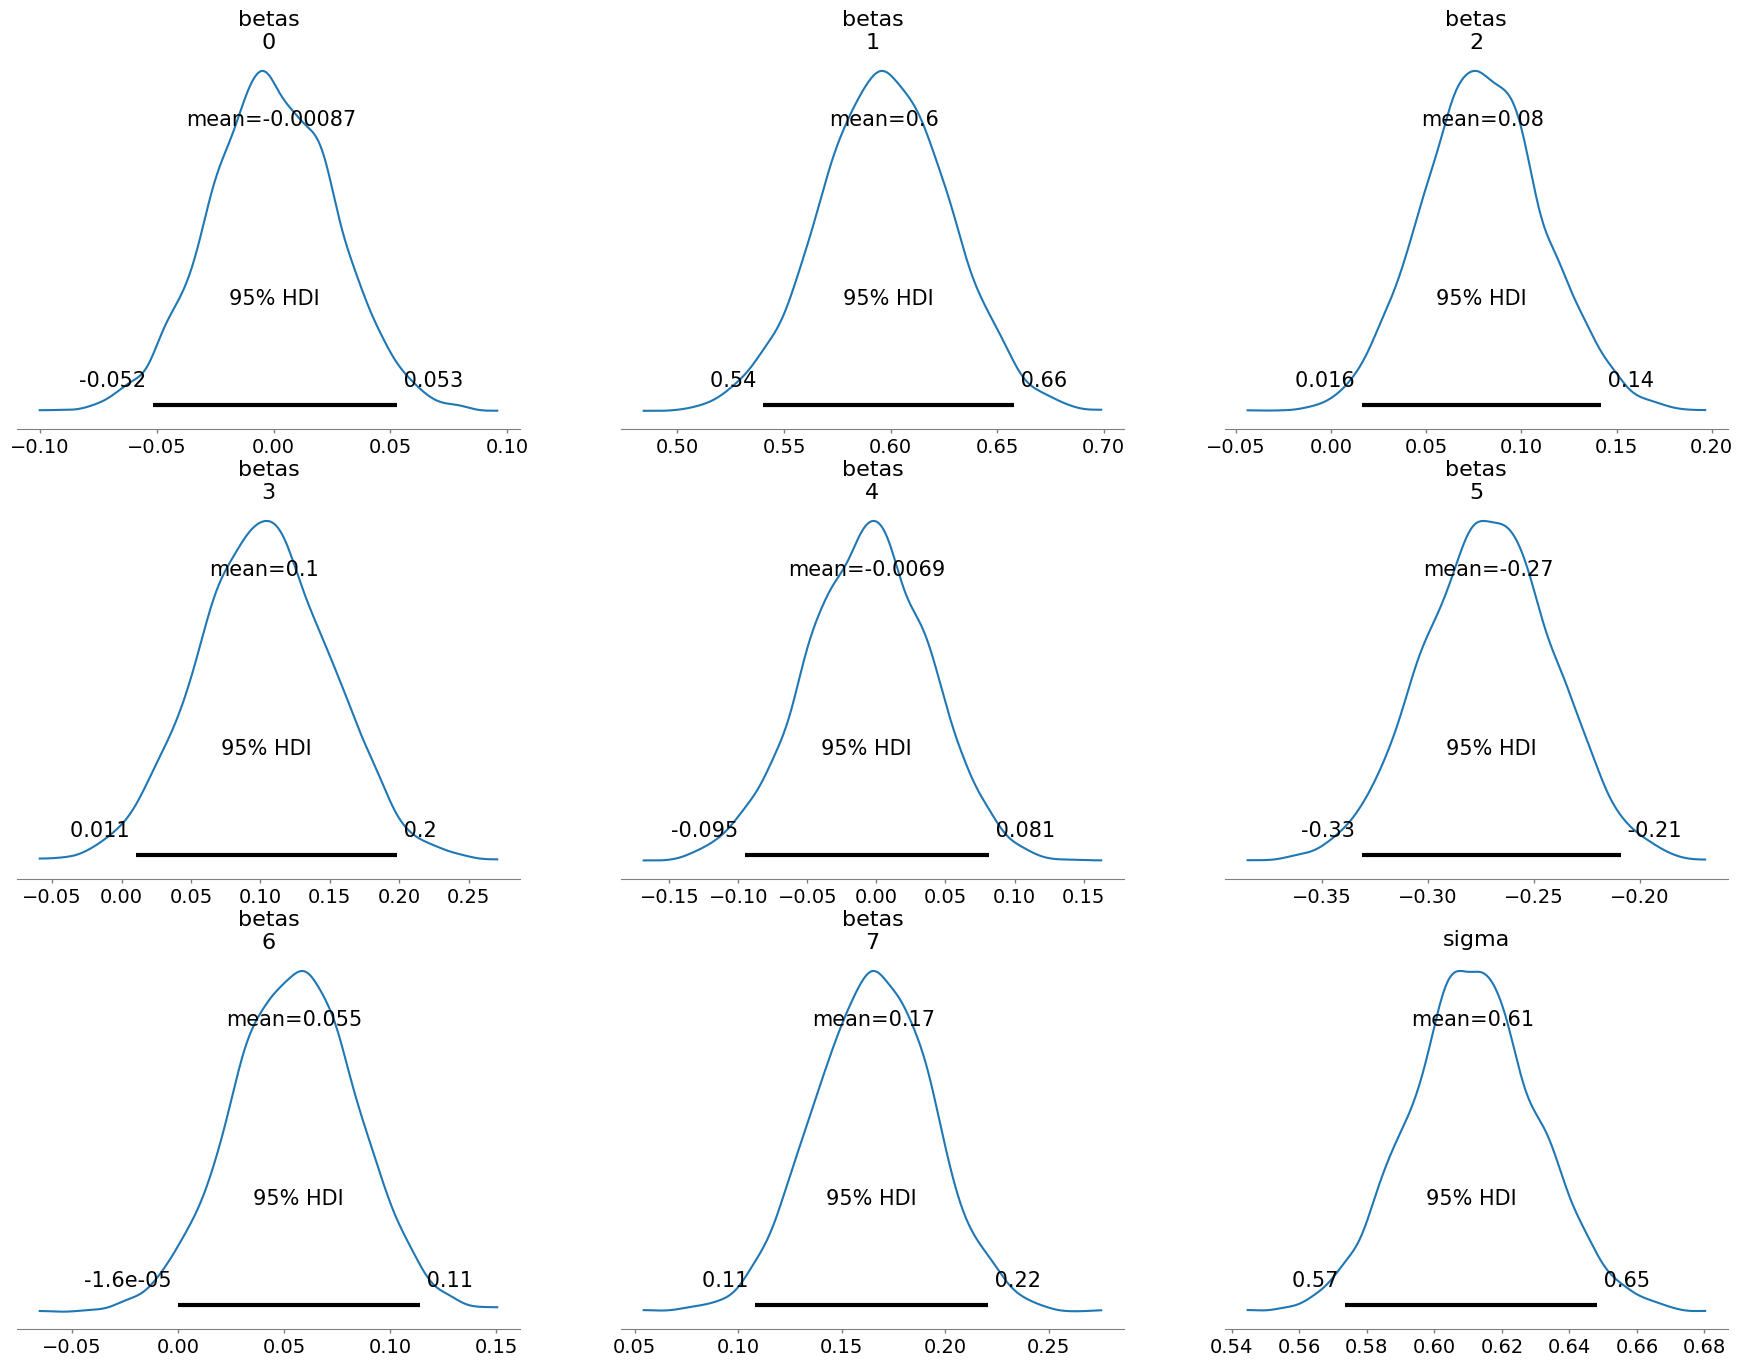

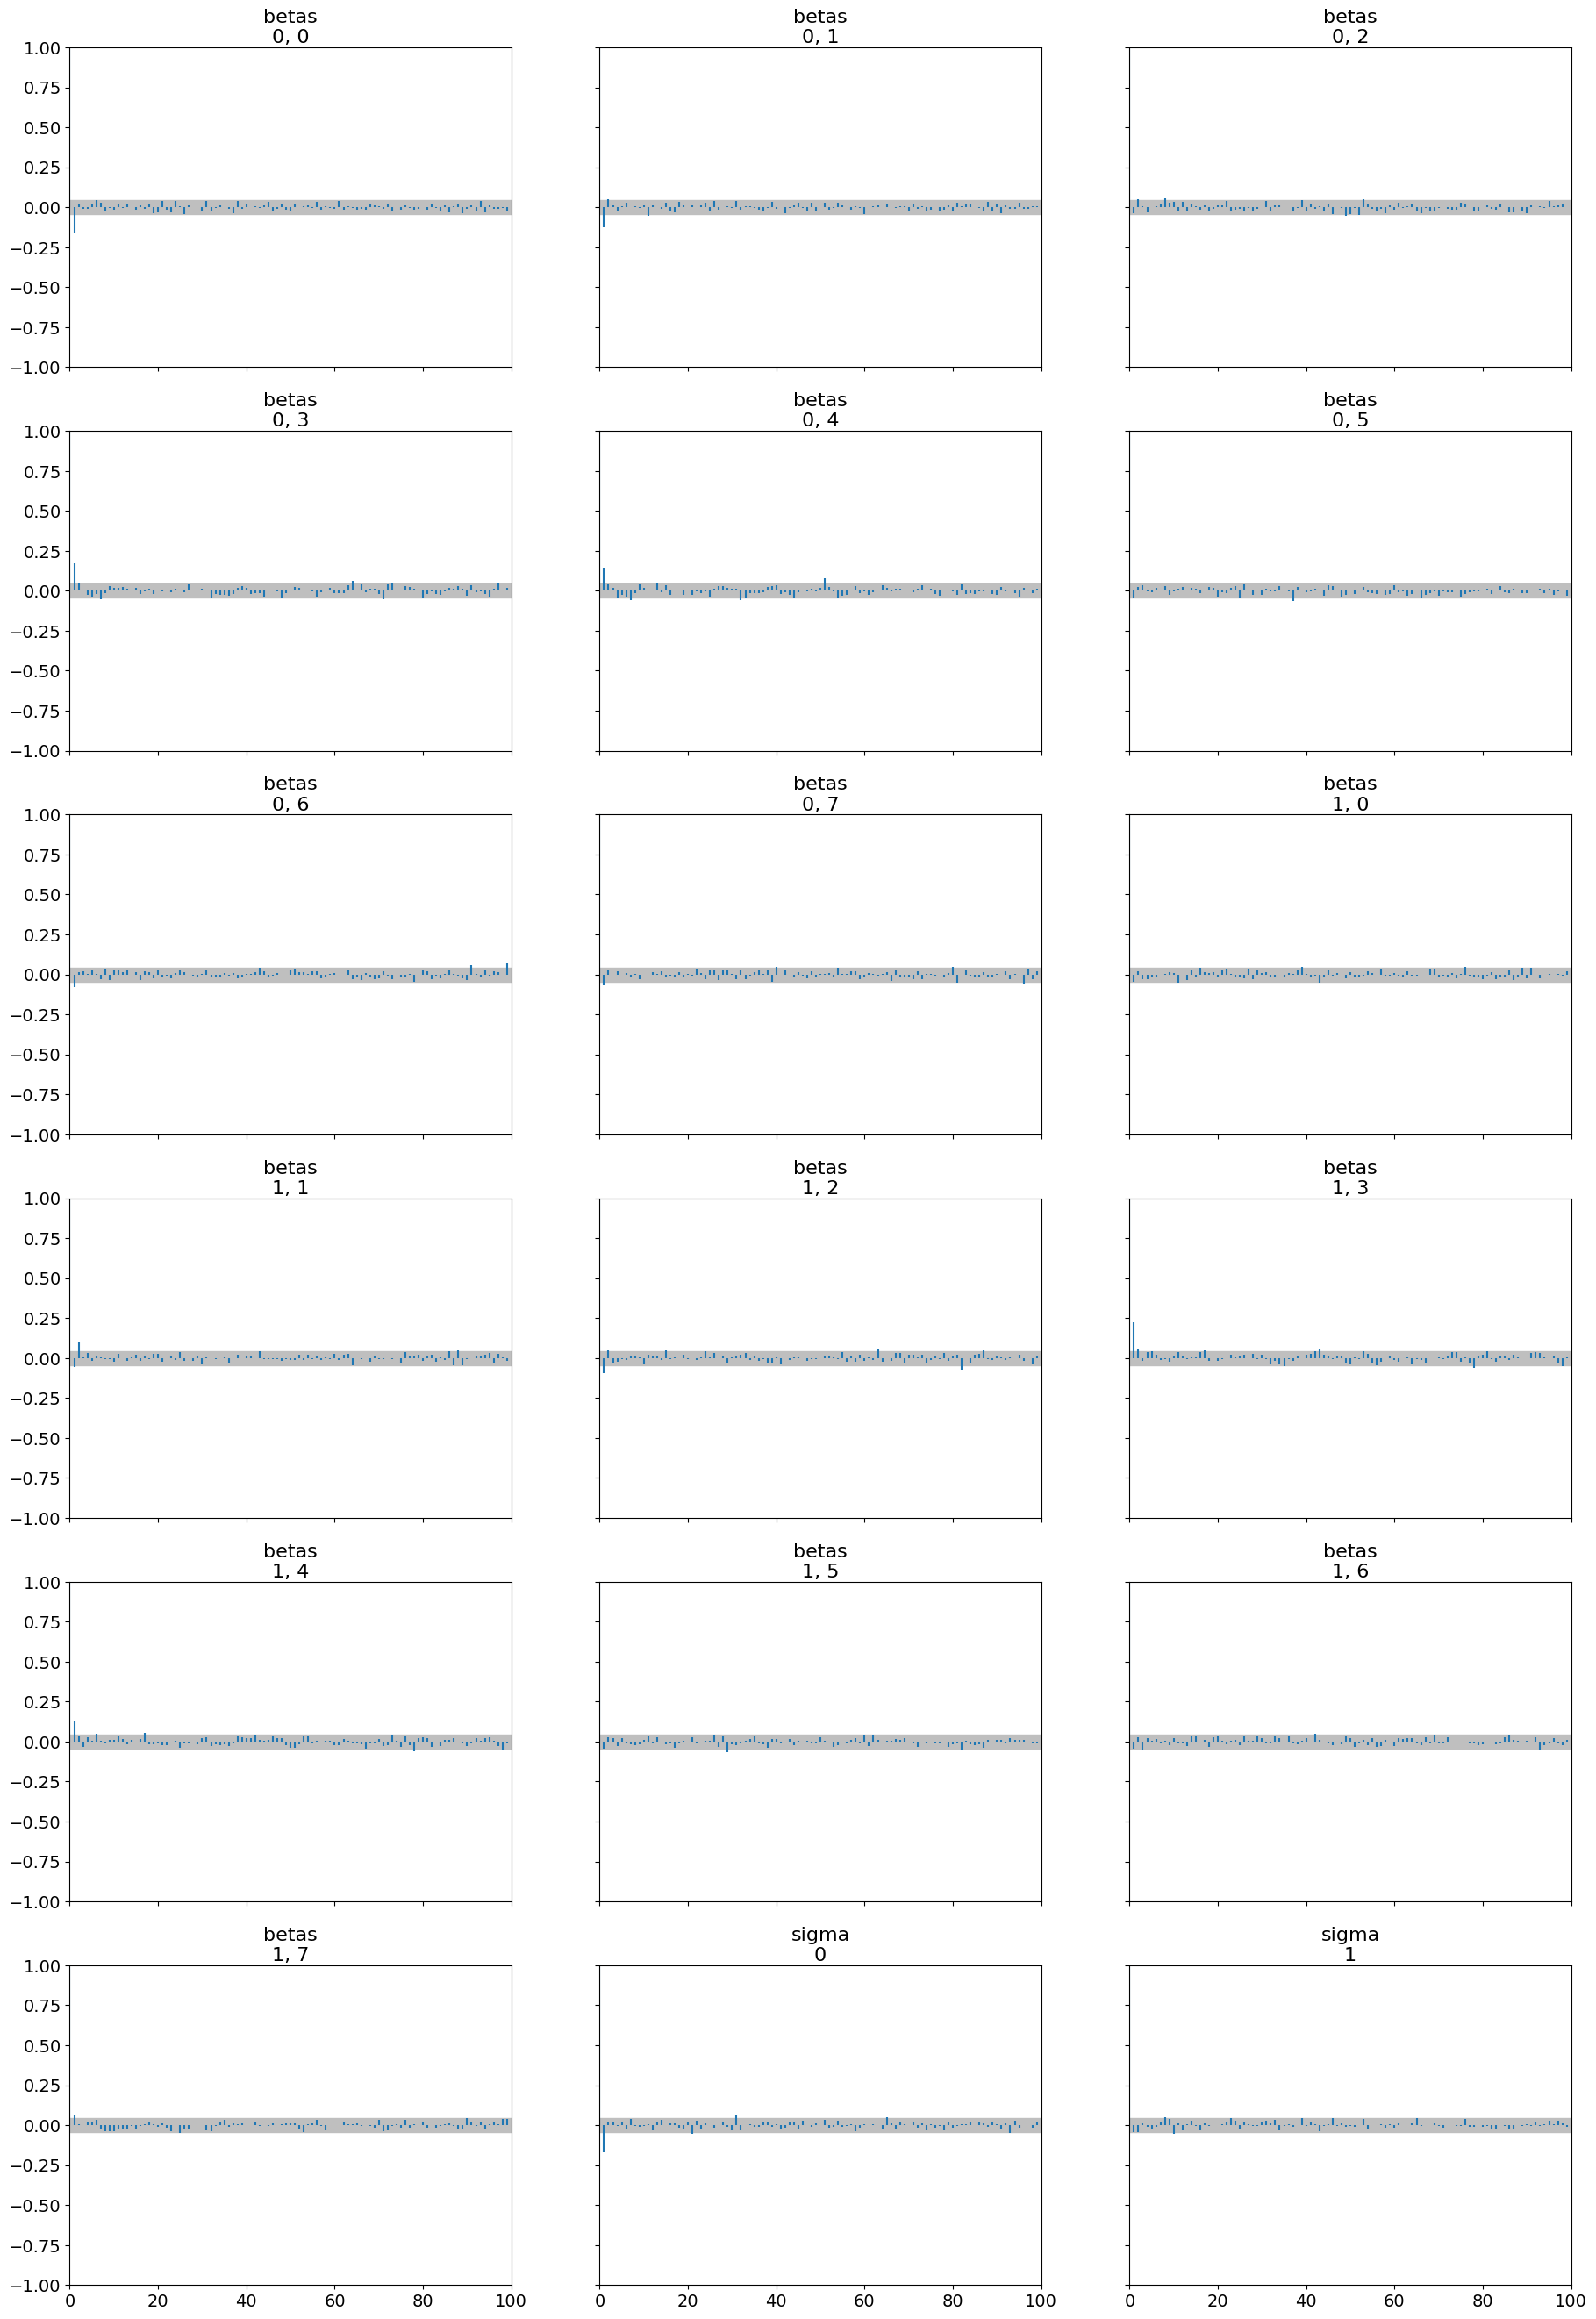

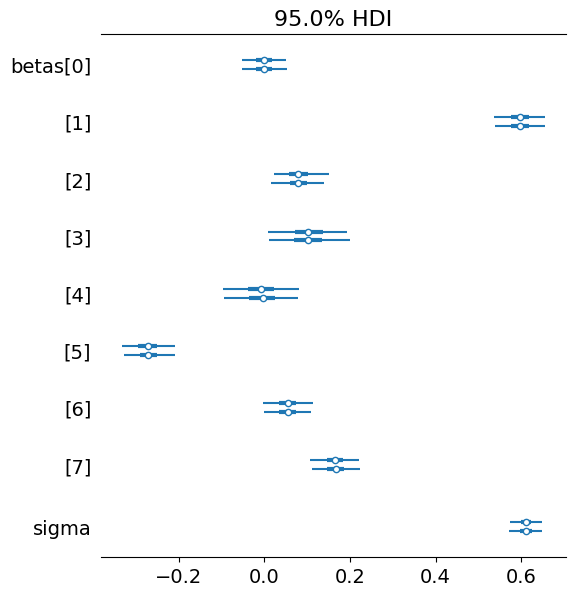

In [ ]:
import pandas as pd
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt


data = pd.read_csv('drive/MyDrive/housing.csv')
data_sample = data.sample(n=500, random_state=42)  # Use data_sample = data for full dataset

# missing values
data_sample['total_bedrooms'] = data_sample['total_bedrooms'].fillna(data_sample['total_bedrooms'].median())

data_sample = pd.get_dummies(data_sample, columns=['ocean_proximity'], drop_first=True)

#X & target y
feature_names = ['intercept', 'median_income', 'housing_median_age', 'total_rooms', 'total_bedrooms'] + \
                [col for col in data_sample.columns if 'ocean_proximity' in col]
X = data_sample[feature_names[1:]]  # Exclude intercept for now
y = data_sample['median_house_value']


y_mean, y_std = y.mean(), y.std()
X_scaled = (X - X.mean()) / X.std()
y_scaled = (y - y_mean) / y_std  # Normalize y
X_scaled = np.array(X_scaled)
y_scaled = np.array(y_scaled)

# Add intercept column
X_scaled = np.c_[np.ones(X_scaled.shape[0]), X_scaled]

# Number of predictors
p = X_scaled.shape[1]

# Bayesian model
with pm.Model() as model:
    betas = pm.Normal('betas', mu=0, sigma=1, shape=p)
    sigma = pm.HalfNormal('sigma', sigma=1)
    mu = pm.math.dot(X_scaled, betas)
    y_obs = pm.Normal('y', mu=mu, sigma=sigma, observed=y_scaled)

    # MCMC sampling
    trace = pm.sample(2000, tune=1000, return_inferencedata=True, target_accept=0.9, random_seed=42)


trace.posterior['betas'].coords['betas_dim_0'] = feature_names

# Diagnostics
print("MCMC Diagnostics:")
print(az.summary(trace, var_names=['betas', 'sigma']))
print("\nR-hat values:")
print(az.rhat(trace))
print("\nEffective Sample Sizes:")
print(az.ess(trace))

#plots
az.plot_trace(trace, var_names=['betas', 'sigma'])
plt.show()

az.plot_posterior(trace, var_names=['betas', 'sigma'], hdi_prob=0.95)
plt.show()

az.plot_autocorr(trace, var_names=['betas', 'sigma'])
plt.show()

az.plot_forest(trace, var_names=['betas', 'sigma'], hdi_prob=0.95)
plt.show()


# Question 3

 Progress                    Draws   Divergences   Step size   Grad evals   Sampling Speed   Elapsed   Remaining  
 ───────────────────────────────────────────────────────────────────────────────────────────────────────────────── 
  ━━━━━━━━━━━━━━━━━━━━━━━━━   3000    0             0.26        15           195.90 draws/s   0:00:15   0:00:00    
  ━━━━━━━━━━━━━━━━━━━━━━━━━   3000    0             0.26        15           96.83 draws/s    0:00:30   0:00:00

           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
betas[0] -0.139  0.019  -0.172   -0.103      0.000    0.000    3183.0   
betas[1]  0.413  0.023   0.370    0.456      0.000    0.000    2151.0   
betas[2]  0.029  0.022  -0.012    0.069      0.000    0.000    3181.0   
betas[3]  0.047  0.035  -0.018    0.110      0.001    0.001    2291.0   
betas[4]  0.005  0.032  -0.053    0.063      0.001    0.000    2210.0   
betas[5] -0.181  0.019  -0.215   -0.145      0.000    0.000    2349.0   
betas[6]  0.046  0.024   0.003    0.092      0.000    0.000    2354.0   
betas[7]  0.146  0.023   0.102    0.186      0.000    0.000    2469.0   
tau       7.897  0.692   6.648    9.236      0.015    0.011    1988.0   

          ess_tail  r_hat  
betas[0]    3012.0    1.0  
betas[1]    2663.0    1.0  
betas[2]    2754.0    1.0  
betas[3]    2869.0    1.0  
betas[4]    2864.0    1.0  
betas[5]    2488.0    1.0  
betas[6]    3125.0    1.0  
betas[7]    3051.0    1.0  
tau         2562.

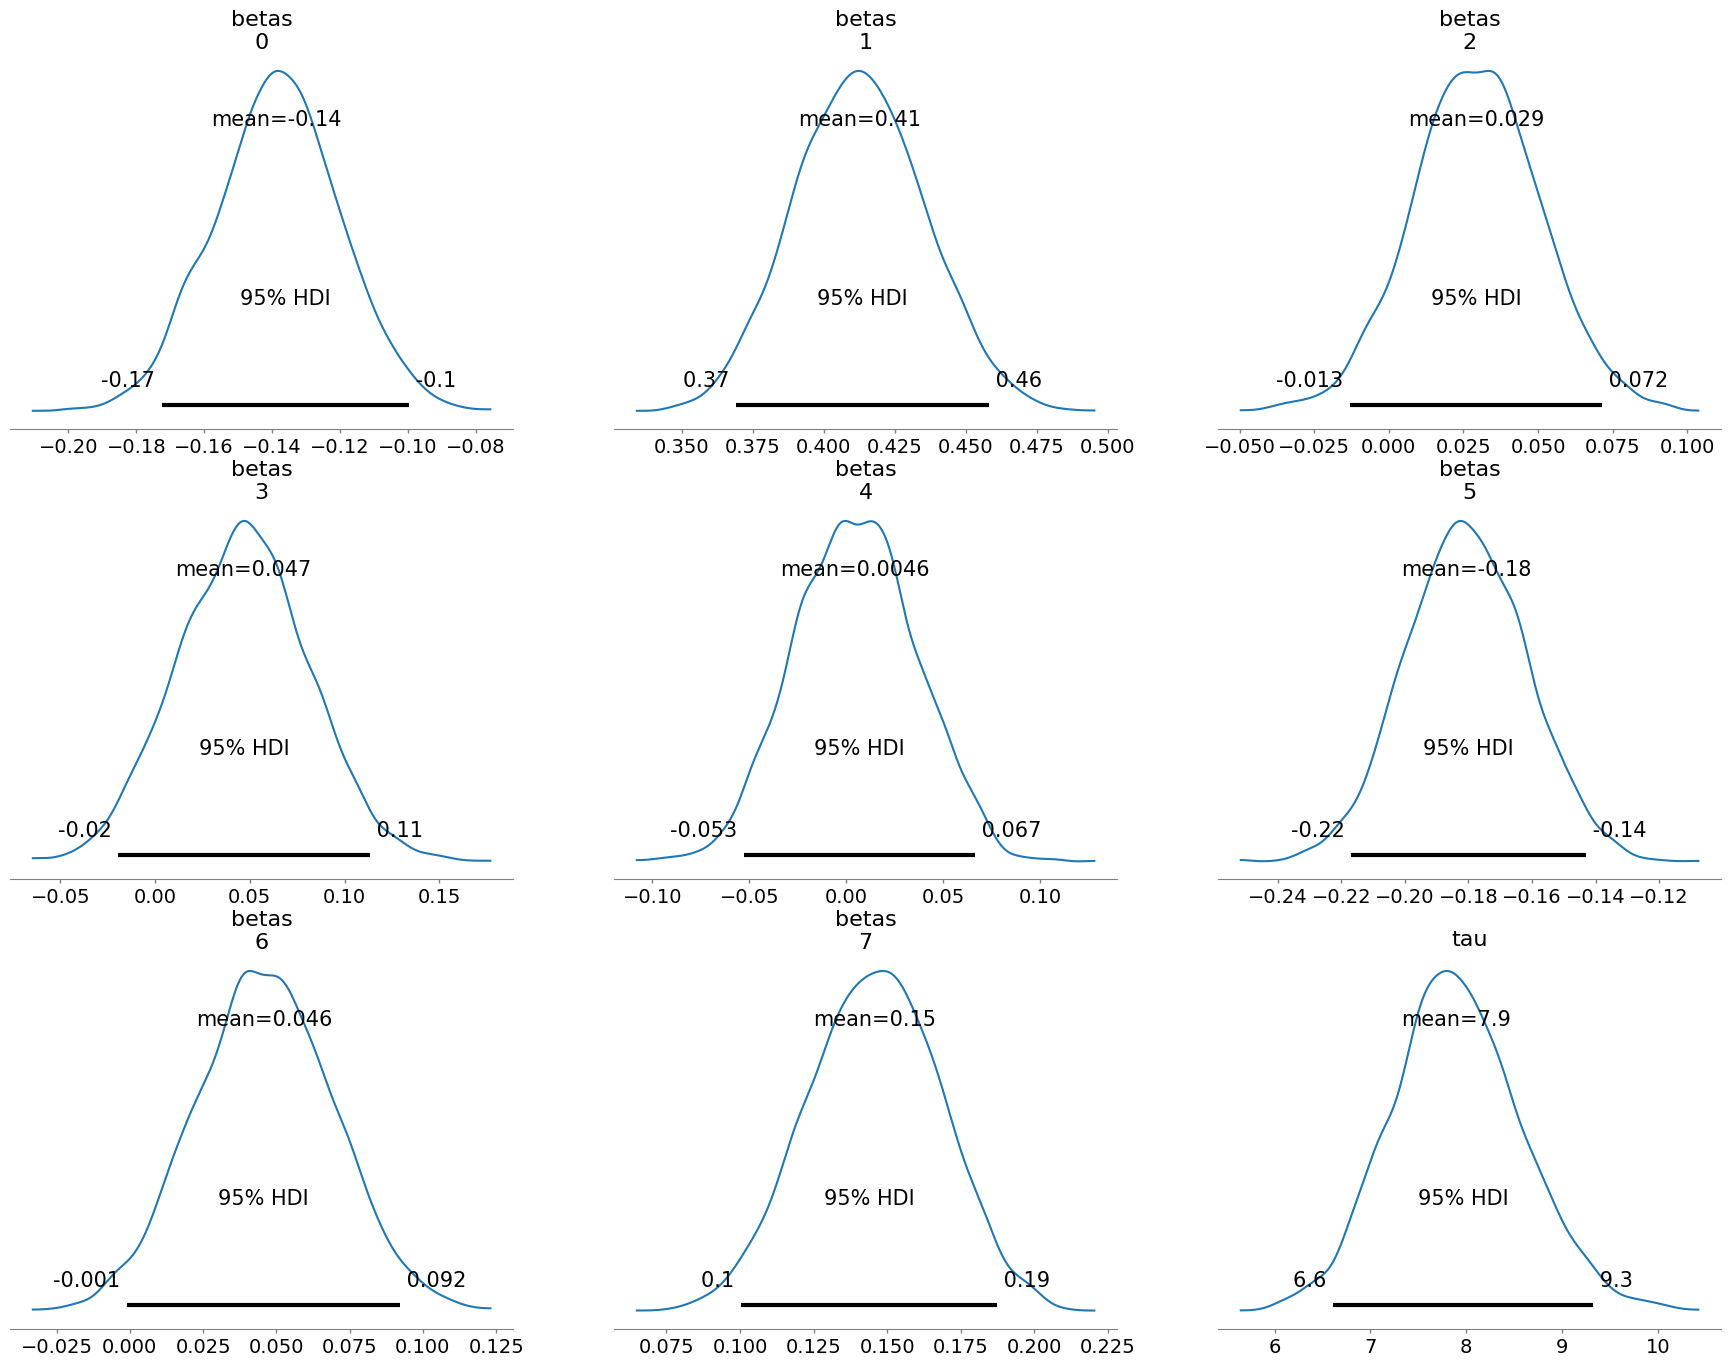


Top 10 Identified Outliers (Indices): [406 194   9 450  84 374 155 361  68 104]
Tau_i values for outliers: [0.01431854 0.01507043 0.01741927 0.02146725 0.02560578 0.04778604
 0.05628253 0.08684199 0.1170615  0.12918114]


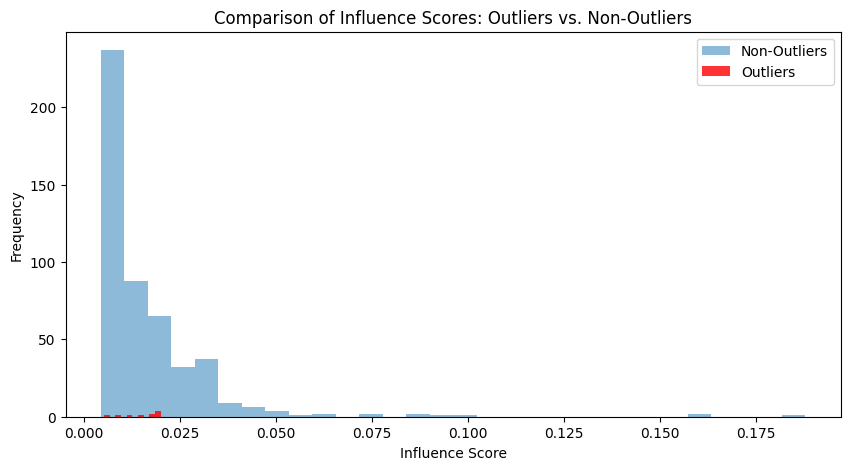

In [ ]:
import pandas as pd
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt

data = pd.read_csv('drive/MyDrive/housing.csv')

data_sample = data.sample(n=500, random_state=42)

np.random.seed(42)
outlier_indices = np.random.choice(data_sample.index, size=20, replace=False)  # Select 20 random points
data_sample.loc[outlier_indices, 'median_house_value'] *= 3  # Make them extreme outliers

data_sample['total_bedrooms'] = data_sample['total_bedrooms'].fillna(data_sample['total_bedrooms'].median())
data_sample = pd.get_dummies(data_sample, columns=['ocean_proximity'], drop_first=True)
X = data_sample[['median_income', 'housing_median_age', 'total_rooms', 'total_bedrooms'] +
                [col for col in data_sample.columns if 'ocean_proximity' in col]]

y = data_sample['median_house_value']

X_scaled = (X - X.mean()) / X.std()
y_scaled = (y - y.mean()) / y.std()
X_scaled = np.array(X_scaled)
y_scaled = np.array(y_scaled)
X_scaled = np.c_[np.ones(X_scaled.shape[0]), X_scaled]
n, p = X_scaled.shape

# Robust Bayesian Linear Regression Model
with pm.Model() as model:
    betas = pm.Normal('betas', mu=0, sigma=1, shape=p)
    tau = pm.Gamma('tau', alpha=1, beta=1)
    nu = 4
    tau_i = pm.Gamma('tau_i', alpha=nu/2, beta=nu/2, shape=n)

    sigma_i = pm.Deterministic('sigma_i', (tau * tau_i) ** -0.5)
    mu = pm.math.dot(X_scaled, betas)
    y_obs = pm.Normal('y_obs', mu=mu, sigma=sigma_i, observed=y_scaled)

    #MCMC sampling
    trace = pm.sample(2000, tune=1000, return_inferencedata=True, target_accept=0.9, random_seed=42)

# MCMC Diagnostics
print(az.summary(trace, var_names=['betas', 'tau']))
print("\nR-hat values:")
print(az.rhat(trace))
print("\nEffective Sample Sizes:")
print(az.ess(trace))

# Plot posterior distributions of coefficients
az.plot_posterior(trace, var_names=['betas', 'tau'], hdi_prob=0.95)
plt.show()

# Identify Outliers: Check the posterior of tau_i
tau_i_posterior = trace.posterior['tau_i'].mean(dim=("chain", "draw")).values

# Sort data points by estimated tau_i
outlier_indices = np.argsort(tau_i_posterior)[:10]  # Lowest tau_i values (highest variance)

print("\nTop 10 Identified Outliers (Indices):", outlier_indices)
print("Tau_i values for outliers:", tau_i_posterior[outlier_indices])

# Compute Influence (Diagonal of Hat Matrix)
X_matrix = np.matrix(X_scaled)
D = np.diag(tau_i_posterior)  # Diagonal precision matrix
H = X_matrix @ np.linalg.inv(X_matrix.T @ D @ X_matrix) @ X_matrix.T
influence_scores = np.diag(H)

# Compare Outliers vs. Non-Outliers Influence Scores
outlier_influence = influence_scores[outlier_indices]
non_outlier_influence = np.delete(influence_scores, outlier_indices)

plt.figure(figsize=(10, 5))
plt.hist(non_outlier_influence, bins=30, alpha=0.5, label="Non-Outliers")
plt.hist(outlier_influence, bins=10, alpha=0.8, label="Outliers", color="red")
plt.xlabel("Influence Score")
plt.ylabel("Frequency")
plt.title("Comparison of Influence Scores: Outliers vs. Non-Outliers")
plt.legend()
plt.show()
